In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
import pickle

In [2]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [3]:
df = pd.read_csv('../../data.csv')

In [4]:
df.head()

,Unnamed: 0,unique_fire_identifier,lattitude,longitude,acres_burned,fire_cause,incident_name,IsFSAssisted,origin_county,state,...,population,d0,d1,d2,d3,d4,DSCI_avg,DSCI_summed,precipitation(in),class
0,34889,2016-IDBOD-000058,-116.330913,43.406206,0.1,Human,SOUTH CLOVER,1.0,Ada,ID,...,1684036.0,8.043333,0.000000,0.000000,0.0,0.0,8.043333,24.13,0.040772,A
1,34890,2016-MNRLA-000184,-94.916910,48.017407,0.1,Undetermined,RL 130,0.0,Beltrami,MN,...,5525360.0,9.663333,1.026667,0.000000,0.0,0.0,11.716667,35.15,0.040886,A
2,34891,2016-MNRLA-000185,-95.015306,47.875908,0.1,Undetermined,RL 131,0.0,Beltrami,MN,...,5525360.0,9.663333,1.026667,0.000000,0.0,0.0,11.716667,35.15,0.040886,A
3,34892,2016-AZA5S-002056,-112.761608,34.201307,0.5,Undetermined,KRISTEE,0.0,Yavapai,AZ,...,6944767.0,32.776667,65.580000,1.170000,0.0,0.0,167.446667,502.34,0.031042,B
4,34893,2016-AZNAA-000033,-108.537233,36.744172,0.5,Human,HOGBACK 1,1.0,San Juan,NM,...,2092555.0,53.023333,43.686667,0.086667,0.0,0.0,140.656667,421.97,0.235141,B


In [5]:
dict2 = { 'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'J':9} # the classes need to be numeric

In [6]:
df['class'] = df['class'].replace(dict2)

In [7]:
df.head() #now we have class 0-9

,Unnamed: 0,unique_fire_identifier,lattitude,longitude,acres_burned,fire_cause,incident_name,IsFSAssisted,origin_county,state,...,population,d0,d1,d2,d3,d4,DSCI_avg,DSCI_summed,precipitation(in),class
0,34889,2016-IDBOD-000058,-116.330913,43.406206,0.1,Human,SOUTH CLOVER,1.0,Ada,ID,...,1684036.0,8.043333,0.000000,0.000000,0.0,0.0,8.043333,24.13,0.040772,0
1,34890,2016-MNRLA-000184,-94.916910,48.017407,0.1,Undetermined,RL 130,0.0,Beltrami,MN,...,5525360.0,9.663333,1.026667,0.000000,0.0,0.0,11.716667,35.15,0.040886,0
2,34891,2016-MNRLA-000185,-95.015306,47.875908,0.1,Undetermined,RL 131,0.0,Beltrami,MN,...,5525360.0,9.663333,1.026667,0.000000,0.0,0.0,11.716667,35.15,0.040886,0
3,34892,2016-AZA5S-002056,-112.761608,34.201307,0.5,Undetermined,KRISTEE,0.0,Yavapai,AZ,...,6944767.0,32.776667,65.580000,1.170000,0.0,0.0,167.446667,502.34,0.031042,1
4,34893,2016-AZNAA-000033,-108.537233,36.744172,0.5,Human,HOGBACK 1,1.0,San Juan,NM,...,2092555.0,53.023333,43.686667,0.086667,0.0,0.0,140.656667,421.97,0.235141,1


In [8]:
def over_sampler(df,column_name):
    ''' Params: df,column_name="string" 
    The function will oversample based on the class you want to match. Save as df and then use train_test_split to cut down 
    the data.
      '''
    
    df=df.copy()
    # gathering the classes/counts and respective percentages to convert to dictionary for easy accesiblilty later
    classes = df[column_name].value_counts(normalize=False).index.tolist()
    counts = df[column_name].value_counts(normalize=False).tolist()
    percentages = (round(df[column_name].value_counts(normalize=True)*100,3)).tolist()
    diction=dict(zip(classes,counts))
    
    # getting input data so we can quckly iterate
    input_user = int(input('What class do we want from needs to be an INT(our case ~ 0-9)?'))
    count_goal = diction.get(input_user)
    # creating list of dataframes of randomly oversample observations 
    #            Note: not usable for time series w/o adjustment as to what df passed in 
    df_list = []
    for k,v in diction.items():
        # ensuring oversampling classes w/counts below the designated input class
        if v < count_goal:
            n_samples=count_goal-v
            rows_to_append = df[df[column_name]==k].sample(n =n_samples,replace=True,random_state=42) # oversampling here
            df_list.append(rows_to_append)

    # merging list of dfs into on whole df 
    samples_df = pd.concat(df_list)
    # merging dataframe of oversamples obs to original passed in df to return
    over_sample_class =pd.concat([df,samples_df])
    
    return over_sample_class

        

In [10]:
over_class = over_sampler(df,'class')
print(over_class.shape[0])
over_class['class'].value_counts()

What class do we want from needs to be an INT(our case ~ 0-9)? 3


219739


0    55304
1    38521
2    22983
5    18769
4    17182
3    13396
8    13396
6    13396
7    13396
9    13396
Name: class, dtype: int64

We oversample the smaller classes to build a more balanced model. Now each class smaller then class 3 is the same size as class 3. 

In [11]:
X = over_class[['precipitation(in)', 'value', 'area (acres)', 'population', 'lattitude', 'longitude', 'month', 'year']] #these features gave me the best results
y = over_class['class']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify =y, random_state =42)

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
rf = RandomForestClassifier(n_estimators = 10)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

In [15]:
rf.score(X_train, y_train) 

0.9797699084973666

In [16]:
rf.score(X_test, y_test)

0.7098571038500046

In [18]:
y_pred = rf.predict(X_test)

In [19]:
f1_score(y_test, y_pred, average = 'macro')

0.7786070420844855

f1 score is our target metric.

In [20]:
cm = confusion_matrix(y_test, y_pred)

In [21]:
cm_df = pd.DataFrame(cm,
                     index = ['A','B','C', 'D','E','F','G','H','I','J'], 
                     columns = ['A','B','C', 'D','E','F','G','H','I','J'])

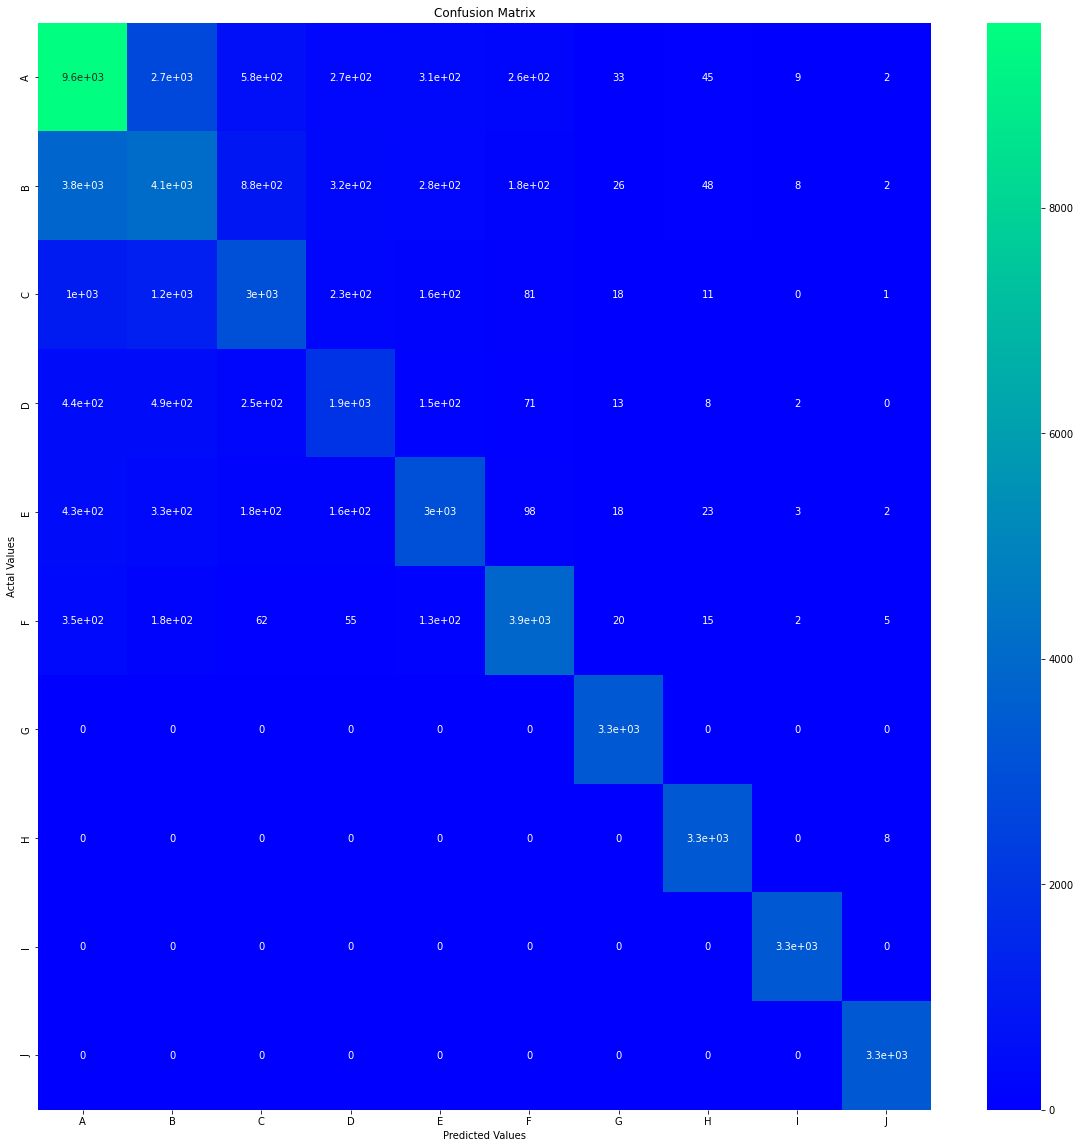

In [22]:
#Plotting the confusion matrix
plt.figure(figsize=(20,20))
sns.heatmap(cm_df, annot=True, cmap = 'winter')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [23]:
gb = GradientBoostingClassifier(n_estimators = 10)
gb.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=10)

In [24]:
gb.score(X_train, y_train) 

0.4529744423679037

In [25]:
gb.score(X_test, y_test)

0.45022299080731776

In [26]:
y_pred2 = gb.predict(X_test)

In [27]:
f1_score(y_test, y_pred2, average = 'macro')

0.3778893685831448

The random forest model is better

In [28]:
ab = AdaBoostClassifier(n_estimators = 10)
ab.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=10)

In [29]:
ab.score(X_train, y_train) 

0.3519817480158249

In [30]:
ab.score(X_test, y_test)

0.35181578228815874

In [31]:
y_pred3 = ab.predict(X_test)

In [32]:
f1_score(y_test, y_pred3, average = 'macro')

0.19828222148013502

The random forest model is better

In [34]:
kn = KNeighborsClassifier()
kn.fit(X_train, y_train)

KNeighborsClassifier()

In [35]:
kn.score(X_train, y_train) 

0.7883121768889104

In [36]:
kn.score(X_test, y_test)

0.7084372440156549

In [37]:
y_pred4 = kn.predict(X_test)

In [38]:
f1_score(y_test, y_pred4, average = 'macro')

0.7731192660029682